# Summary
MESH is a POC (Proof of Concept) of high accurate Iris Recognition algorithm. Tested on CASIA_V1 dataset with manual labeled pupil circular, the 1-on-1 cross matching accuracy is 100%. After rejecting several low quality images, the theoritical ERR (Equal Error Rate) can be as low as 1/1billion.

MESH_Open is part of MESH which was open sourced in this repository. MESH_Open has a cross matching accuracy of 99.9965%, or 10 errors in a total of 285,390 1-on-1 cross matchings.

A main advantage of MESH is that the Same Iris Histogram and the Not Same Iris Histogram are far apart, well separated. Which indicates that Iris Recognition has the potential to achieve very high cross matching accuracy, e.g. 1/1billion.

# WorkFlow
## Iris Location
Manual labeled pupil circular data were used, because MESH focuses on feature matching, and I do not have a good Iris Location/Segmentation algorithm. Notes that the manual labeled pupil circulars are not accurate at all. I labelled it myself, sometimes there are 10 pixels offset from ground truth. With a good Iris Location algorithm MESH can do even better. 

The Iris circular is setup as same center of Pupil, radius 100 pixels.

## Normalization
Simply stretch the Iris circular disk to a rectangle.


## Encoding
Gabor Filter was used for Iris Encoding. Source code was borrowed from mvjq's repository 
https://github.com/mvjq/IrisRecognition.

## Template Matching
MESH focuses on Iris Template Matching. The main idea is to divides the normalized Iris Rectangles into small blocks, then calculates HD (Hamming Distance) between the small blocks. It is a flexible HD calculating algorithm, which can handle the distortion in Iris streching. As a result, MESH_Open achieves cross matching accuracy 99.9965%. MESH uses advanced algorithm and achieves accuracy 100%. 

## 1-On-1 Cross Matching
Each Iris was matched with all other Irises. Histogram of Same Iris and Not Same Iris were plotted together and compared.

Each Iris Matching takes about 0.12 seconds on Intel(R) Core(TM) i7-8565U CPU (single thread). It takes about 10 hours to run a full cross matching. One of the disadvantage of MESH Feature Matching is its speed.

In [1]:
import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

import cv2
import numpy as np
import glob
import math
import scipy
from time import time
from scipy.spatial import distance
from scipy import signal
from scipy.stats import binom, norm
import matplotlib.pyplot as plt
import pandas as pd

import plotly.express as px

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
import plotly.graph_objs as go
import plotly.io as pio
init_notebook_mode(connected=True)

# Functions and Constants

In [2]:
def draw_circle(img, c):
    return cv2.circle(cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2RGB), (c[1], c[0]), round(c[2]), (255,255,255), 1)

In [3]:
# iris circular to rect
def norm_iris(img, c, r_iris):
    [cy, cx, r_pupil, _] = c
    
    # fix r_iris 100
    r_iris = 100
    
    _padding = 0
    img_rect = cv2.linearPolar(img, (cx, cy), r_iris + _padding, cv2.WARP_FILL_OUTLIERS)
    img_rect = cv2.rotate(img_rect, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img_rect = cv2.resize(img_rect, (600, r_iris + _padding), interpolation=cv2.INTER_AREA)
    img_rect = img_rect[:(r_iris - r_pupil + _padding * 2), :]
    img_rect = cv2.resize(img_rect, (600, 60), interpolation=cv2.INTER_AREA)

    img_rect = cv2.equalizeHist(img_rect)
    
    return img_rect

In [4]:
# Gabor encoding, From: https://github.com/mvjq/IrisRecognition
def encode_iris(arr_polar, arr_noise, minw_length, mult, sigma_f):
    """
    Generate iris template and noise mask from the normalised iris region.
    """
    # convolve with gabor filters
    filterb = gaborconvolve_f(arr_polar, minw_length, mult, sigma_f)
    l = arr_polar.shape[1]
    template = np.zeros([arr_polar.shape[0], 2 * l])
    h = np.arange(arr_polar.shape[0])

    # making the iris template
    mask_noise = np.zeros(template.shape)
    filt = filterb[:, :]

    # quantization and check to see if the phase data is useful
    H1 = np.real(filt) > 0
    H2 = np.imag(filt) > 0

    H3 = np.abs(filt) < 0.0001
    for i in range(l):
        ja = 2 * i

        # biometric template
        template[:, ja] = H1[:, i]
        template[:, ja + 1] = H2[:, i]

    return template, mask_noise


def gaborconvolve_f(img, minw_length, mult, sigma_f):
    """
    Convolve each row of an imgage with 1D log-Gabor filters.
    """
    rows, ndata = img.shape
    logGabor_f = np.zeros(ndata)
    filterb = np.zeros([rows, ndata], dtype=complex)

    radius = np.arange(ndata/2 + 1) / (ndata/2) / 2
    radius[0] = 1

    # filter wavelength
    wavelength = minw_length

    # radial filter component 
    fo = 1 / wavelength
    logGabor_f[0: int(ndata/2) + 1] = np.exp((-(np.log(radius/fo))**2) /
                                    (2 * np.log(sigma_f)**2))
    logGabor_f[0] = 0

    # convolution for each row
    for r in range(rows):
        signal = img[r, 0:ndata]
        imagefft = np.fft.fft(signal)
        filterb[r, :] = np.fft.ifft(imagefft * logGabor_f)
    
    return filterb

In [5]:
def get_gabor_encoded_img(img, c):
    minw_length = 18
    mult = 1
    sigma_f = 0.5

    img_rect = norm_iris(img, c, c[2] + iris_depth)
    img_gabor_rect, mask_noise = encode_iris(img_rect, np.zeros(img_rect.shape), minw_length, mult, sigma_f)
    img_gabor_rect = (img_gabor_rect * 255).astype(np.uint8)
    
    return img_gabor_rect[:, ::2], img_gabor_rect[:, 1::2]

In [6]:
# get hamming distance of 2 iris rects
def get_hd_of_img_i_j(img0, img1):
    key_points_0 = key_points.copy()
    key_points_1 = []
    hd_map = []
    
    for kp in key_points_0:
        feature_0 = img0[kp[0]-hsp:kp[0]+hsp, kp[1]-hsp:kp[1]+hsp]
        feature_1 = img1[kp[0]-sp:kp[0]+sp, kp[1]-sp:kp[1]+sp]

        # quality check
#         feature_0_mean, feature_1_mean = feature_0.mean(), feature_1.mean() 
#         if((feature_0_mean > 255*0.4 and feature_0_mean < 255*0.6) and (feature_1_mean > 255*0.41 and feature_1_mean < 255*0.59)):
        feature_match_map = cv2.filter2D(feature_1, -1, feature_0/feature_0.sum())
        feature_match_map_0 = cv2.filter2D((255 - feature_1), -1, (255 - feature_0)/(255 - feature_0).sum())
        feature_match_map = (feature_match_map.astype(np.int) + feature_match_map_0.astype(np.int)) / 2

        salt = np.random.rand(feature_match_map.shape[0], feature_match_map.shape[1])
        feature_match_map = feature_match_map.astype(np.float32) + salt

        kp_match_ind = np.unravel_index(feature_match_map.argmax(), feature_match_map.shape)
        kp_match_offset = kp_match_ind - np.array([sp, sp])
        kp_match = np.array(kp) + kp_match_offset

        key_points_1.append(kp_match)

        hd_map.append(feature_match_map[kp_match_ind[0]][kp_match_ind[1]])
        
    select_hd = pd.DataFrame(hd_map)[0] > thresh_hd
    
    return key_points_1, np.sum(select_hd), hd_map

In [7]:
N_tested = 756 # number of tested images
iris_depth = 60 # height of normed iris rect
thresh_hd = int(0.7 * 255)
percentile_hd = .75

# Load CASIA V1 images and pupil centers

In [8]:
files = []
for i in range(1, 109):
    files.extend(sorted(glob.glob('CASIA1/' + str(i) + '/*.jpg')))

print("N# of files which we are extracting features", len(files))

# for f in files:
#     print(f)

N# of files which we are extracting features 756


In [9]:
cirpupils = pd.read_csv('casia_v1_circle_pupil.csv')
cirpupils

,cx,cy,r,f
0,134,182,37,001_1_1
1,138,173,39,001_1_2
2,119,173,39,001_1_3
3,122,182,39,001_2_1
4,145,177,39,001_2_2
...,...,...,...,...
751,141,164,46,108_1_3
752,145,169,43,108_2_1
753,132,164,47,108_2_2
754,126,181,43,108_2_3


In [10]:
img_oris = [cv2.imread(_, 0) for _ in files[:N_tested]]

# Observe Pupil Circle

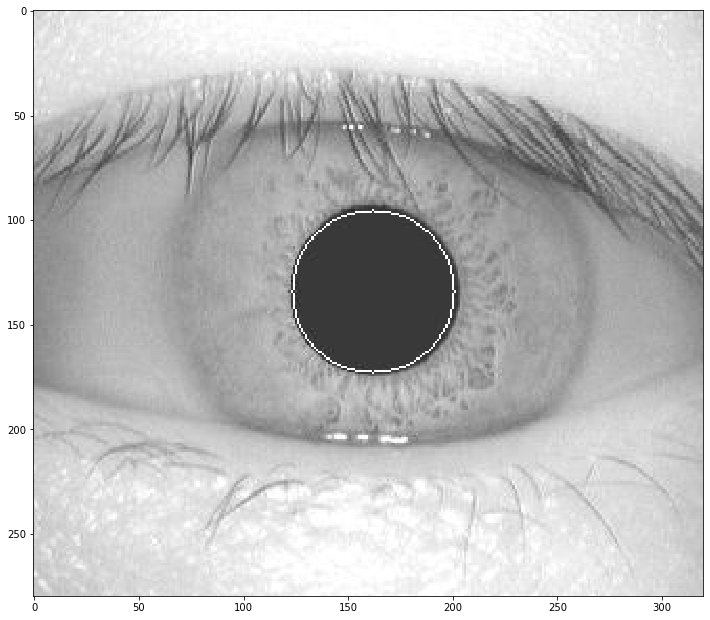

In [11]:
ti = 333

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(draw_circle(img_oris[ti], list(cirpupils.iloc[ti])), interpolation='nearest')

In [12]:
list(cirpupils.iloc[ti])

[134, 162, 39, '048_2_2']

# Observe sample images, rects, templates

CASIA1/1\001_1_3.jpg
CASIA1/1\001_2_2.jpg


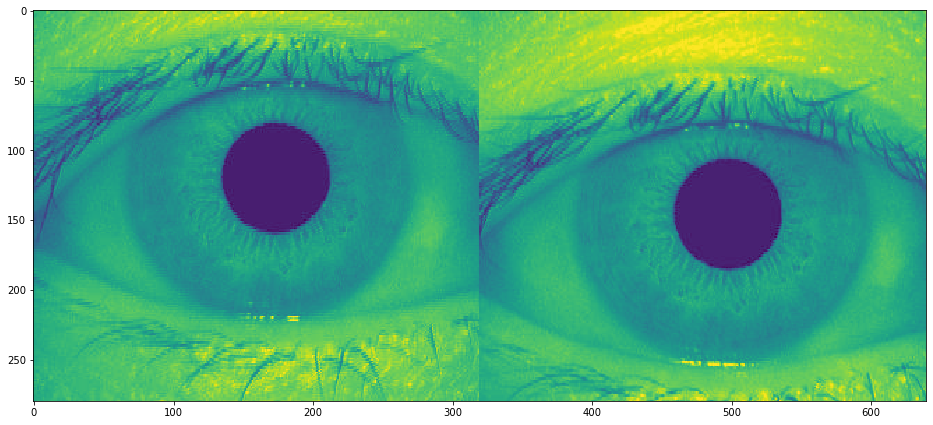

In [13]:
t0, t1 = 2, 4 # index of sample images
print(files[t0])
print(files[t1])

fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(np.hstack((img_oris[t0], img_oris[t1])), interpolation='nearest')

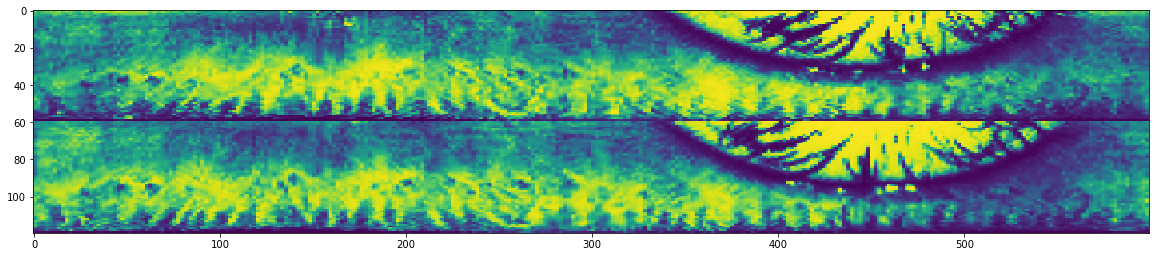

In [14]:
fig, ax = plt.subplots(figsize=(20, 16))
ax.imshow(np.vstack((norm_iris(img_oris[t0], cirpupils.iloc[t0], cirpupils.iloc[t0][2] + iris_depth), 
                     norm_iris(img_oris[t1], cirpupils.iloc[t1], cirpupils.iloc[t1][2] + iris_depth))), interpolation='nearest')

In [15]:
img_gabor_rects = []
for i in range(len(img_oris)):
    template_ori = get_gabor_encoded_img(img_oris[i], cirpupils.iloc[i])
    template_pat = []
    template_pat.append(np.hstack((template_ori[0], template_ori[0][:, :30])))
    template_pat.append(np.hstack((template_ori[1], template_ori[1][:, :30])))
    
    img_gabor_rects.append(template_pat)

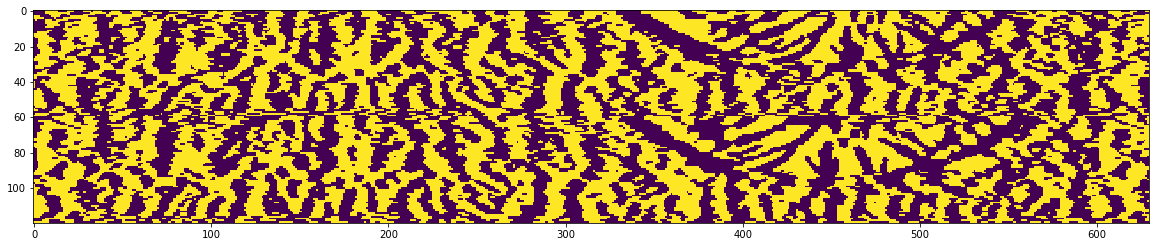

In [16]:
fig, ax = plt.subplots(figsize=(20, 16))
ax.imshow(np.vstack((img_gabor_rects[t0][0], img_gabor_rects[t1][0])), interpolation='nearest')

# Define mesh points

In [17]:
h_rect, w_rect = img_gabor_rects[0][0].shape

n_h, n_w = 5, 60 # N feature points on H, W
sp = 30 # size of HD area
hsp = int(sp*0.5) # half of sp

step_h = (h_rect - sp) / (n_h - 1)
step_w = (w_rect - sp) / (n_w - 1)

key_points = []
for i in range(n_h):
    _k_h = i * step_h + sp
    for j in range(n_w):
        _k_w = j * step_w + sp
        key_points.append([int(_k_h), int(_k_w)])
        
print(h_rect, w_rect, step_h, step_w)

60 630 7.5 10.169491525423728


# Sample of mesh Hamming Distance map

In [18]:
kp = key_points[20]

feature_0 = img_gabor_rects[t0][0][kp[0]-hsp:kp[0]+hsp, kp[1]-hsp:kp[1]+hsp]
feature_1 = img_gabor_rects[t1][0][kp[0]-sp:kp[0]+sp, kp[1]-sp:kp[1]+sp]

feature_match_map = cv2.filter2D(feature_1, -1, feature_0/feature_0.sum())

kp_match_ind = np.unravel_index(feature_match_map.argmax(), feature_match_map.shape)
kp_match_offset = kp_match_ind - np.array([hsp, hsp])
kp_match = np.array(kp) + kp_match_offset
print(kp_match, feature_match_map[kp_match_ind[0]][kp_match_ind[1]], feature_0.mean(), feature_1.mean())

[ 45 249] 209 126.93333333333334 126.79166666666667


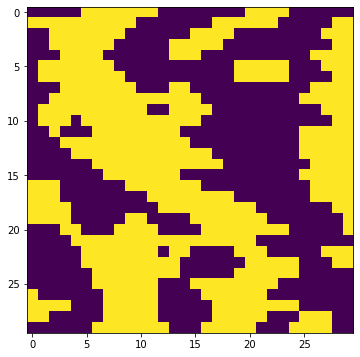

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(feature_0, interpolation='nearest')

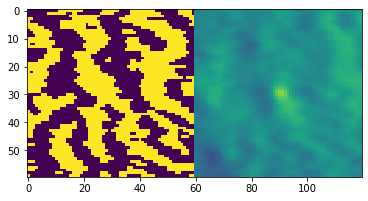

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(np.hstack((feature_1, feature_match_map)), interpolation='nearest')

In [21]:
key_points_1, n_selected, hd_map = get_hd_of_img_i_j(img_gabor_rects[t0][0], img_gabor_rects[t1][0])
print(n_selected, np.percentile(hd_map, percentile_hd))

263 162.46694784040025


# Cross Matching
## It takes about 10h to run a full cross matching.

In [19]:
np.random.seed(42)

start_time = time()
recs = []
for i in range(N_tested-1):
    if(i % 10 == 0):
        print(i)
    for j in range(i+1, min(N_tested, N_tested)):
        if(i != j):
            _, n_selected1, hd_map = get_hd_of_img_i_j(img_gabor_rects[i][0], img_gabor_rects[j][0])
            _, n_selected2, hd_map_2 = get_hd_of_img_i_j(img_gabor_rects[j][0], img_gabor_rects[i][0])
            
            recs.append([i, j, n_selected, n_selected2, np.percentile(hd_map, percentile_hd), np.percentile(hd_map_2, percentile_hd)])
print('time cost: %d' % int(time() - start_time))

0
10
time cost: 27


In [22]:
df_hd = pd.DataFrame(data=recs, columns=['i', 'j', 'n_selected1', 'n_selected2', 'hd1', 'hd2'])
df_hd['hd'] = (df_hd['hd1'] + df_hd['hd2']) / 2

df_hd['fi'] = df_hd['i'].apply(lambda x: files[x].split('\\')[1][:3])
df_hd['fj'] = df_hd['j'].apply(lambda x: files[x].split('\\')[1][:3])
df_hd['fi_'] = df_hd['i'].apply(lambda x: files[x].split('\\')[1][:7])
df_hd['fj_'] = df_hd['j'].apply(lambda x: files[x].split('\\')[1][:7])
df_hd['same'] = df_hd['fi'] == df_hd['fj']

# Histogram of Hamming Distance, FRR/FAR. ERR: 0.0035%
## Load pre run HD data.

In [23]:
df_hd = pd.read_csv('casia_v1_hd.csv', index_col=None)

df_hd.sort_values(by='hd', inplace=True, ascending=True)
df_hd[df_hd['same']].head(10)

,i,j,n_selected1,n_selected2,hd1,hd2,hd,fi,fj,fi_,fj_,same
2760,631,633,105,84,180.887616,178.563221,179.725418,91,91,091_1_2,091_2_1,True
2603,631,636,105,72,182.509967,177.433182,179.971574,91,91,091_1_2,091_2_4,True
2366,701,703,105,88,181.422471,180.132189,180.777330,101,101,101_1_2,101_2_1,True
2306,631,635,105,104,180.868237,182.221165,181.544701,91,91,091_1_2,091_2_3,True
2286,438,440,105,92,183.373344,180.394407,181.883875,63,63,063_2_2,063_2_4,True
2279,437,440,105,95,183.683203,180.393591,182.038397,63,63,063_2_1,063_2_4,True
2278,631,634,105,107,181.899327,182.186621,182.042974,91,91,091_1_2,091_2_2,True
2263,746,748,105,116,181.696388,183.805258,182.750823,107,107,107_2_2,107_2_4,True
2260,435,437,105,135,181.808093,184.187037,182.997565,63,63,063_1_2,063_2_1,True
2259,485,489,105,121,183.235026,182.904405,183.069715,70,70,070_1_3,070_2_4,True


In [24]:
df_hd.sort_values(by='hd', inplace=True, ascending=False)
df_hd[~df_hd['same']].head(10)

,i,j,n_selected1,n_selected2,hd1,hd2,hd,fi,fj,fi_,fj_,same
2258,150,564,105,134,183.192303,183.494130,183.343216,22,81,022_2_1,081_2_2,False
2261,336,560,105,110,183.570232,182.318794,182.944513,49,81,049_1_1,081_1_1,False
2262,150,560,105,115,182.366772,183.184374,182.775573,22,81,022_2_1,081_1_1,False
2264,150,566,105,118,182.896116,182.577606,182.736861,22,81,022_2_1,081_2_4,False
2265,87,270,105,128,181.615118,183.392749,182.503934,13,39,013_2_1,039_2_2,False
2266,148,563,105,115,183.241613,181.715818,182.478715,22,81,022_1_2,081_2_1,False
2267,87,599,105,116,181.817212,182.983145,182.400179,13,86,013_2_1,086_2_2,False
2268,152,561,105,113,183.115944,181.647769,182.381857,22,81,022_2_3,081_1_2,False
2269,150,562,105,108,182.800599,181.957364,182.378982,22,81,022_2_1,081_1_3,False
2270,150,563,105,115,182.664960,182.000911,182.332935,22,81,022_2_1,081_2_1,False


In [25]:
# hd
N_bins = 200
counts_same, bins_same = np.histogram(df_hd[df_hd['same']]['hd'].values / 255, bins=[_ / N_bins for _ in range(0, N_bins)])
counts_not_same, bins_not_same = np.histogram(df_hd[df_hd['same'] == False]['hd'].values / 255, bins=[_ / N_bins for _ in range(0, N_bins)])

fig = go.Figure(data=[
    go.Bar(x=bins_same, y=counts_same, name='same'),
    go.Bar(x=bins_not_same, y=counts_not_same * counts_same.sum() / counts_not_same.sum(), name='not same'),
])
fig.show()

In [26]:
fars, frrs, fars_fit = [], [], []
err = 0
for i in range(len(bins_same)):
    frrs.append(counts_same[:i].sum() / counts_same.sum())
    fars.append(counts_not_same[i:].sum() / counts_not_same.sum())

fig = go.Figure(data=[
        go.Scatter(x=bins_not_same, y=frrs, name='frr'),
        go.Scatter(x=bins_same, y=fars, name='far'),
])
fig.show()

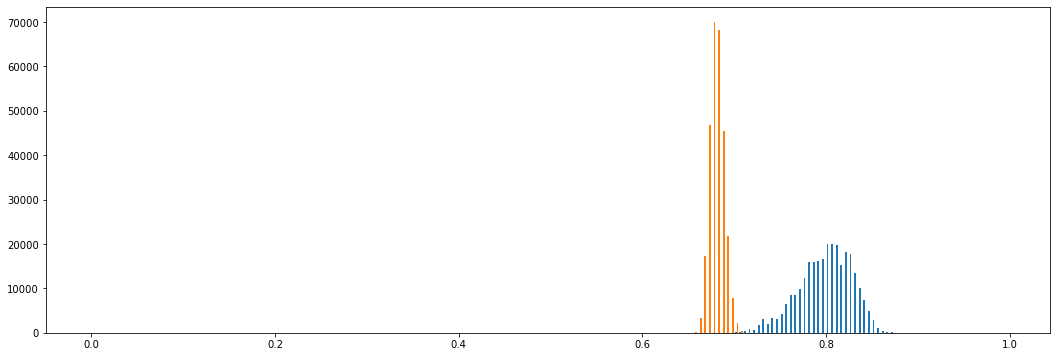

In [27]:
# for matplotlib
_ = plt.hist([
    np.repeat(df_hd[df_hd['same']]['hd'].values, counts_not_same.sum() / counts_same.sum()) / 255, 
    df_hd[df_hd['same'] == False]['hd'].values / 255],
    [_ / N_bins for _ in range(0, N_bins)],
    label=['Same', 'Not Same'])

fig = plt.gcf()
fig.set_size_inches(18, 6)

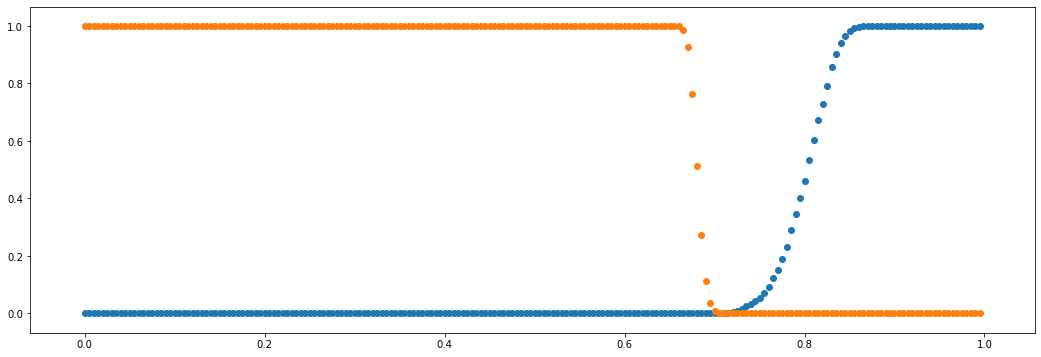

In [28]:
plt.scatter(x=bins_not_same, y=frrs, label='frr')
plt.scatter(x=bins_same, y=fars, label='far')

fig = plt.gcf()
fig.set_size_inches(18, 6)